In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('../..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

from irover_application.extract_features import Processor

In [3]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [4]:
from tqdm import tqdm_notebook
from joblib import Parallel,delayed,effective_n_jobs

In [5]:
import pymorphy2
import nltk

In [6]:
import gensim

In [7]:
assistant_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
assistant_table = list(assistant_table)
assistant_table[0].keys()

dict_keys(['yang_assignments_repeat_1', 'mds_key', 'linguists_sugested_text', 'toloka_text', '_other', 'check_in_yang_results', 'toloka_assignments_repeat_5_with_chorus_and_pitch', 'toloka_assignments_repeat_9_selected_workers_with_chorus_and_pitch', 'date', 'number_of_speakers', 'toloka_assignments_repeat_4_with_bend', 'text', 'raw_text_linguists', 'linguists_comment', 'toloka_assignments_repeat_3_with_pitch', 'toloka_number_of_speakers', 'toloka_assignments_repeat_6_with_chorus', 'toloka_assignments_repeat_1', 'toloka_assignments_repeat_7_with_chorus_and_pitch', 'toloka_assignments_repeat_8_selected_workers_with_chorus_and_pitch', 'speech', 'linguists_worker_id', 'toloka_speech', 'mark', 'toloka_assignments_repeat_11_selected_workers_with_pitch', 'toloka_assignments', 'toloka_assignments_repeat_10', 'toloka_assignments_repeat_2_with_pitch', 'audio', 'url'])

In [8]:
train_rows_q = [row for row in assistant_table if row["mark"] == "TRAIN"]
test_rows_q = [row for row in assistant_table if row["mark"] == "TEST"]
for row in test_rows_q:
    if 'text' in row:
        del row['text']

In [9]:
Context = collections.namedtuple('Context', 'max_num_answers for_fitting platform')
context = Context(10, True, 'toloka')
context

Context(max_num_answers=10, for_fitting=True, platform='toloka')

In [10]:
train_proc_q = Processor(train_rows_q, context)
test_proc_q = Processor(test_rows_q, context)

for row in train_rows_q:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},
            'text': row['text']}
    train_proc_q.rows.append(value)

for row in test_rows_q:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},}
    test_proc_q.rows.append(value)

In [ ]:
test_features = test_proc_q.extract_features()

In [ ]:
train_features = train_proc_q.extract_features()

In [ ]:
fasttext_model = gensim.models.FastText.load_fasttext_format('toloka_logs/fasttext_output.bin')

In [ ]:
fasttext_model.most_similar(positive=['включить'])

In [ ]:
import json

In [ ]:
path = 'toloka_logs/assistant_raw_logs.jsonl'
all_tokens = []
with open(path) as inf:
    for line in tqdm_notebook(inf):
        line_parsed = json.loads(line.strip())['raw_assesments']
        if line_parsed:
            for assesment in line_parsed:
                all_tokens += assesment['text'].lower().replace('ё','е').split()

In [ ]:
valid_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
valid_table = list(valid_table)

In [ ]:
valid_rows = [row for row in valid_table if row["mark"] == "TEST"]

In [ ]:
zero_vector = np.zeros_like(fasttext_model.wv['?'])

def get_embedding(word):
    if word in fasttext_model.wv:
        return fasttext_model.wv[word]
    else:
        return zero_vector

def convert_to_array(features):
    X = list()
    Y = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    embedding = get_embedding(word)
                    X.append(np.concatenate((np.array(x), embedding)))
                    Y.append(1 if y else -1)
    return np.array(X), np.array(Y)

In [ ]:
X_train_q, Y_train_q = convert_to_array(train_features)

In [107]:
clf_q = CatBoostClassifier(iterations=23000, depth=7, thread_count=30, random_seed=42, verbose=3)
clf_q.fit(X_train_q, Y_train_q)
with open("log_assistant.txt", "a") as log:
    log.write("embedding/catboost model is fitted\n")

CatBoostError: Bad value for num_feature[0,0]="[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.76000000e+02  2.42603550e-01  3.67011834e+00  2.16494083e+01
  1.18343195e-02  2.02662722e-01  2.81065089e-02  1.00000000e+00
  6.00000000e+00  3.20000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]": Cannot convert obj [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.76000000e+02  2.42603550e-01  3.67011834e+00  2.16494083e+01
  1.18343195e-02  2.02662722e-01  2.81065089e-02  1.00000000e+00
  6.00000000e+00  3.20000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00] to float

In [ ]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, 
                              cluster_references=None, preaggregated=None):
    """
       aggregation from prod
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost:
                if score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [ ]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

In [ ]:
import hashlib

In [ ]:
def reproducible_hash(s: str):
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])

    text, text_rate = max(texts.items(),
                          key=lambda x: (
                              x[1],
                              x[0] != "",
                              -x[0].count('?'),
                              reproducible_hash(x[0])  # for reproducible behavior
                          ))
    if text_rate >= 2:  # and text != "":
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    return AggregationResult(text, conf, cost)

In [ ]:
import utils.metrics as utils_metrics

In [ ]:
evaluate_metrics = utils_metrics.evaluate_metrics_for_algorithm

In [ ]:
# Prod baseline
prod_agg_metrics = utils_metrics.evaluate_metrics_for_algorithm(valid_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    aggregate_prod)

In [ ]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True,
                          agg_method=aggregate_rover_with_clf_):
    aggregation_results = agg_method(data, 
                                     features, 
                                     field_name, 
                                     clf, 
                                     treshhold=treshhold, 
                                     min_cost=min_cost, 
                                     max_cost=max_cost, 
                                     cluster_references=cluster_refernces)
    return utils_metrics.evaluate_metrics_from_dict(data, 
                                              aggregation_results, 
                                              0,
                                              cluster_refernces, 
                                              print_)

In [ ]:
import seaborn as sns
sns.set(style="whitegrid")

In [37]:
import pickle

In [38]:
with open('../pickled/base_line_new_metrics_solo_assistant.pickle', 'rb') as f:
    baseline_loaded_new_metrics = pickle.load(f)
baseline_loaded_new_metrics

array([0.948     , 0.8560986 , 0.06822048, 4.00143431])

In [35]:
from functools import partial

In [39]:
with open('../pickled/preaggregated_assistant_with_solo_assistant_question.pickle', 'rb') as f:
    preaggregated = pickle.load(f)
len(preaggregated)

3486

In [75]:
scores_clf_test_q = []

for treshhold in np.linspace(0.8, 0.98, 19):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_rows, 
                                    test_features_q, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    clf_q, 
                                    treshhold,
                                    min_cost=3,
                                    max_cost=7,
                                    agg_method=partial(aggregate_rover_with_clf_,
                                                       preaggregated=preaggregated))
    scores_clf_test_q.append((treshhold, *metrics))
scores_clf_test_q = np.array(scores_clf_test_q)

0.8
Recall: 94.3209%
WER: 13.1776%
Mean overlap: 3.045
0.81
Recall: 94.3756%
WER: 13.1307%
Mean overlap: 3.056
0.8200000000000001
Recall: 94.2947%
WER: 12.9829%
Mean overlap: 3.07
0.8300000000000001
Recall: 94.3309%
WER: 12.9463%
Mean overlap: 3.083
0.8400000000000001
Recall: 94.3627%
WER: 12.8098%
Mean overlap: 3.112
0.85
Recall: 94.1797%
WER: 12.6762%
Mean overlap: 3.139
0.86
Recall: 94.2562%
WER: 12.5229%
Mean overlap: 3.174
0.87
Recall: 94.0446%
WER: 12.3408%
Mean overlap: 3.212
0.88
Recall: 94.0428%
WER: 12.0643%
Mean overlap: 3.256
0.89
Recall: 93.7299%
WER: 11.6419%
Mean overlap: 3.321
0.9
Recall: 93.0573%
WER: 11.0704%
Mean overlap: 3.387
0.91
Recall: 92.4659%
WER: 10.4187%
Mean overlap: 3.459
0.92
Recall: 91.4170%
WER: 9.6412%
Mean overlap: 3.552
0.9299999999999999
Recall: 89.6275%
WER: 8.6915%
Mean overlap: 3.676
0.94
Recall: 87.8162%
WER: 7.6132%
Mean overlap: 3.835
0.95
Recall: 85.0765%
WER: 6.5872%
Mean overlap: 4.049
0.96
Recall: 80.3061%
WER: 5.4006%
Mean overlap: 4.345


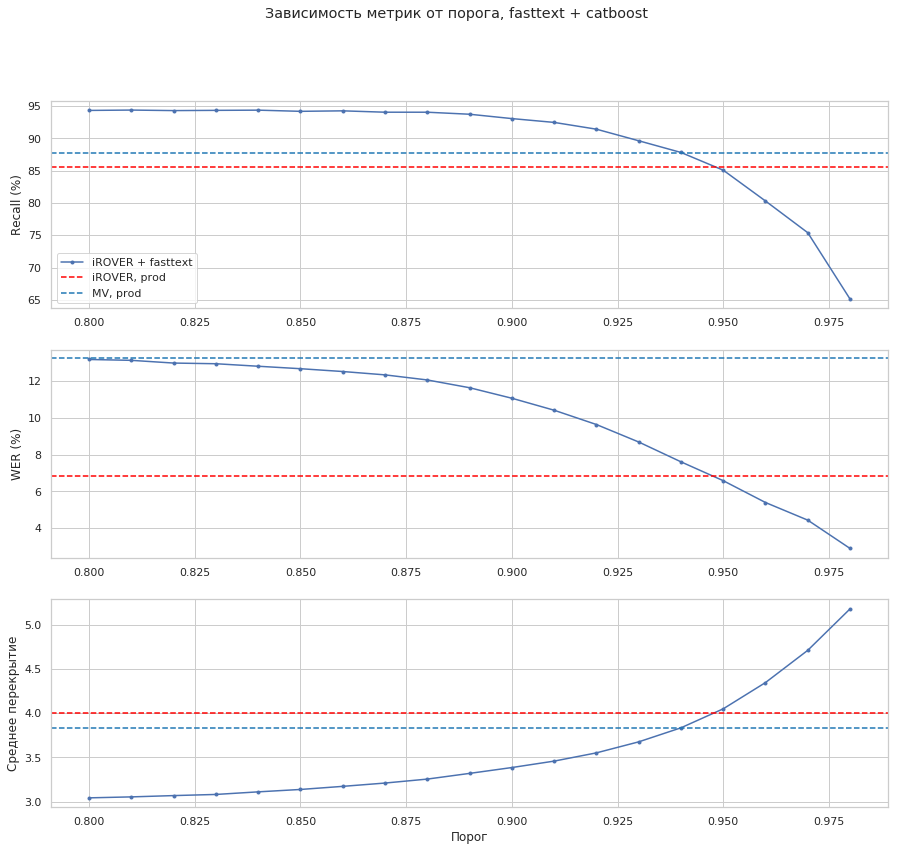

In [77]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от порога, fasttext + catboost')
plt.subplot(311)
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 1] * 100, 
         ".-", 
         label="iROVER + fasttext")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, prod")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.legend()
plt.ylabel('Recall (%)')

plt.subplot(312)
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 2] * 100, 
         ".-")
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 3], 
         ".-")
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("fasttext_and_catboost.png")
plt.show()

In [ ]:
clf = CatBoostClassifier(iterations=19000, thread_count=15, random_seed=42)
params = {"iterations": [19000, 23000, 27000], "depth": [5, 7, 9]}
gs = GridSearchCV(clf, params, 'roc_auc', cv=5, refit=True, n_jobs=2)

In [ ]:
gs.fit(X_train_q, Y_train_q)
with open("log_assistant.txt", "a") as log:
    log.write("model is fitted\n")

In [41]:
gs.best_params_

{'depth': 7, 'iterations': 27000}

In [43]:
def preaggregate_with_clf(features, clf):
    matching = dict()
    X = list()
    for task_id, item0 in features.items():
        task_id = '/'.join(task_id.split('/')[-2:])
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    embedding = get_embedding(word)
                    X.append(np.concatenate((np.array(x), embedding)))
                    matching[(task_id, cost, position, word)] = len(X) - 1
    probabilites = clf.predict_proba(X)[:, 1]
    results = dict()
    for task_id, item0 in features.items():
        task_id = '/'.join(task_id.split('/')[-2:])
        results[task_id] = dict()
        for cost, item1 in sorted(item0.items()):
            results[task_id][cost] = list()
            for position, item2 in sorted(item1.items()):
                words = list(item2.keys())
                probs = np.array([probabilites[matching[(task_id, cost, position, word)]] for word in words])
                pos = np.argmax(probs)
                score = probs[pos]
                word = words[pos]
                results[task_id][cost].append((word, score))
    return results

In [44]:
scores_gs_test = []

for treshhold in np.linspace(0.8, 0.98, 19):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_rows, 
                                    test_features, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    gs, 
                                    treshhold,
                                    min_cost=3,
                                    max_cost=7,
                                    agg_method=partial(aggregate_rover_with_clf_,
                                                       preaggregated=None))
    scores_gs_test.append((treshhold, *metrics))
scores_gs_test = np.array(scores_gs_test)

0.8
Recall: 94.3872%
WER: 13.0559%
Mean overlap: 3.059
0.81
Recall: 94.3676%
WER: 13.0221%
Mean overlap: 3.068
0.8200000000000001
Recall: 94.3659%
WER: 12.9300%
Mean overlap: 3.084
0.8300000000000001
Recall: 94.2968%
WER: 12.8393%
Mean overlap: 3.103
0.8400000000000001
Recall: 94.3384%
WER: 12.7577%
Mean overlap: 3.128
0.85
Recall: 94.3298%
WER: 12.4715%
Mean overlap: 3.159
0.86
Recall: 94.2442%
WER: 12.3362%
Mean overlap: 3.194
0.87
Recall: 94.0936%
WER: 12.0263%
Mean overlap: 3.236
0.88
Recall: 93.7828%
WER: 11.7250%
Mean overlap: 3.279
0.89
Recall: 93.4790%
WER: 11.3049%
Mean overlap: 3.342
0.9
Recall: 92.7428%
WER: 10.8389%
Mean overlap: 3.401
0.91
Recall: 91.8485%
WER: 10.3285%
Mean overlap: 3.488
0.92
Recall: 90.9564%
WER: 9.1779%
Mean overlap: 3.593
0.9299999999999999
Recall: 89.5464%
WER: 8.4431%
Mean overlap: 3.721
0.94
Recall: 87.8240%
WER: 7.6162%
Mean overlap: 3.865
0.95
Recall: 84.9609%
WER: 6.5257%
Mean overlap: 4.113
0.96
Recall: 80.5221%
WER: 5.3214%
Mean overlap: 4.365

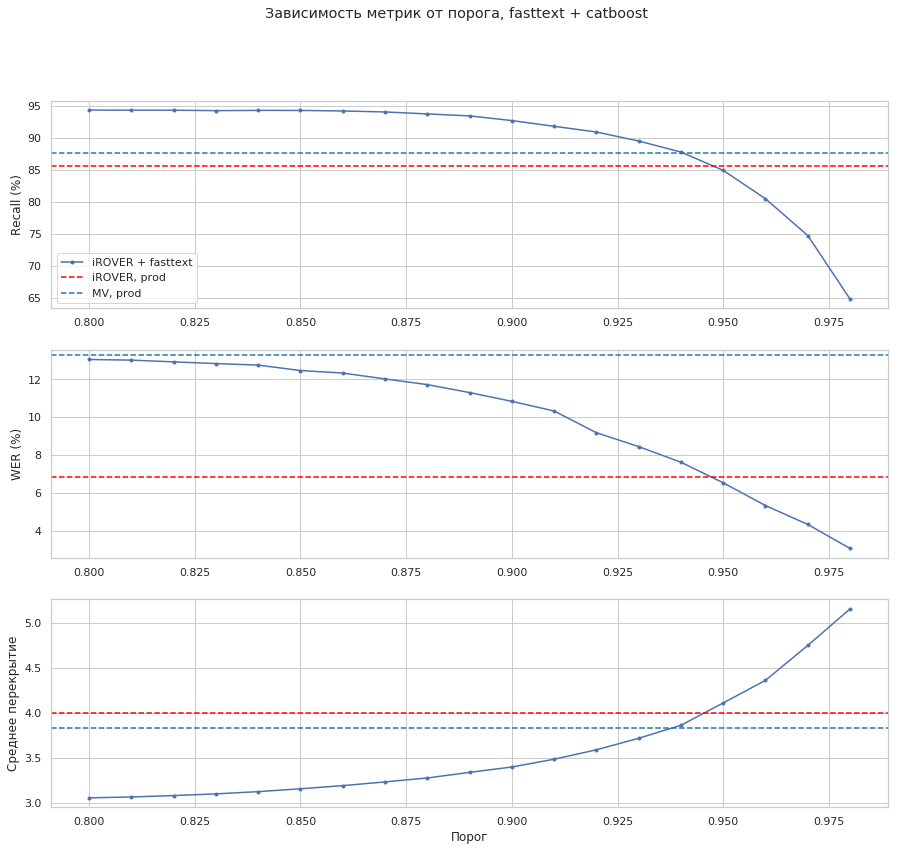

In [45]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от порога, fasttext + catboost')
plt.subplot(311)
plt.plot(scores_gs_test[:, 0], 
         scores_gs_test[:, 1] * 100, 
         ".-", 
         label="iROVER + fasttext")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, prod")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.legend()
plt.ylabel('Recall (%)')

plt.subplot(312)
plt.plot(scores_gs_test[:, 0], 
         scores_gs_test[:, 2] * 100, 
         ".-")
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
plt.plot(scores_gs_test[:, 0], 
         scores_gs_test[:, 3], 
         ".-")
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("fasttext_and_catboost.png")
plt.show()